In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np 
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re 
from datetime import datetime 
from pathlib import Path

from aind_behavior_gym.dynamic_foraging.task import (CoupledBlockTask,
                                                     RandomWalkTask,
                                                     UncoupledBlockTask)
from aind_dynamic_foraging_models import generative_model
from aind_dynamic_foraging_models.generative_model import ForagerCollection
from aind_behavior_gym.dynamic_foraging.agent.random_agent import RandomAgent, RandomAgentBiasedIgnore
from aind_dynamic_foraging_models.generative_model.params import ParamsSymbols
from aind_dynamic_foraging_models.generative_model.params.util import get_params_options
from aind_dynamic_foraging_basic_analysis import compute_foraging_efficiency


sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/learning_dynamics_behavior/metric_dev/foraging_choice')
from foraging_choice import compute_foraging_choice

sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils')
import behavior_utils as bu
import array_utils as au
import load_utils as lu


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Test RL Agents in FC environment #####

In [2]:
forager_collection = ForagerCollection()
df = forager_collection.get_all_foragers()
df.columns

Index(['agent_class_name', 'agent_kwargs', 'agent_alias',
       'number_of_learning_rate', 'number_of_forget_rate', 'choice_kernel',
       'action_selection', 'preset_name', 'n_free_params', 'params', 'forager',
       'win_stay_lose_switch'],
      dtype='object')

In [3]:
df[['agent_class_name', 'preset_name', 'n_free_params', 'params']]

,agent_class_name,preset_name,n_free_params,params
0,ForagerQLearning,None,3,"ParamsSymbols.learn_rate, ParamsSymbols.biasL,..."
1,ForagerQLearning,Rescorla-Wagner,3,"ParamsSymbols.learn_rate, ParamsSymbols.biasL,..."
2,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
3,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
4,ForagerQLearning,None,5,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
5,ForagerQLearning,None,5,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
6,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."
7,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."
8,ForagerQLearning,Bari2019,5,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."
9,ForagerQLearning,None,5,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."


In [4]:
df['params'].unique()

array(['ParamsSymbols.learn_rate, ParamsSymbols.biasL, ParamsSymbols.softmax_inverse_temperature',
       'ParamsSymbols.learn_rate, ParamsSymbols.biasL, ParamsSymbols.epsilon',
       'ParamsSymbols.learn_rate, ParamsSymbols.choice_kernel_step_size (fixed), ParamsSymbols.choice_kernel_relative_weight, ParamsSymbols.biasL, ParamsSymbols.softmax_inverse_temperature',
       'ParamsSymbols.learn_rate, ParamsSymbols.choice_kernel_step_size (fixed), ParamsSymbols.choice_kernel_relative_weight, ParamsSymbols.biasL, ParamsSymbols.epsilon',
       'ParamsSymbols.learn_rate, ParamsSymbols.choice_kernel_step_size, ParamsSymbols.choice_kernel_relative_weight, ParamsSymbols.biasL, ParamsSymbols.softmax_inverse_temperature',
       'ParamsSymbols.learn_rate, ParamsSymbols.choice_kernel_step_size, ParamsSymbols.choice_kernel_relative_weight, ParamsSymbols.biasL, ParamsSymbols.epsilon',
       'ParamsSymbols.learn_rate, ParamsSymbols.forget_rate_unchosen, ParamsSymbols.biasL, ParamsSymbols.softmax_i

In [5]:
# Initialize agent

forager = ForagerCollection().get_preset_forager('Hattori2019', seed=42)
forager.set_params(
    softmax_inverse_temperature=5,
    biasL=0
)

# Create task environment

task = CoupledBlockTask(reward_baiting=True, num_trials=1000, seed=42)

In [6]:
forager.params

ParamsModel(learn_rate_rew=0.5, learn_rate_unrew=0.1, forget_rate_unchosen=0.2, biasL=0.0, softmax_inverse_temperature=5.0)

Foraging efficiency: 0.7725 (random seed: 0.7769607843137255)
foraging_choice_local: 0.42366421104240537, (foraging_choice_global: 0.3155)


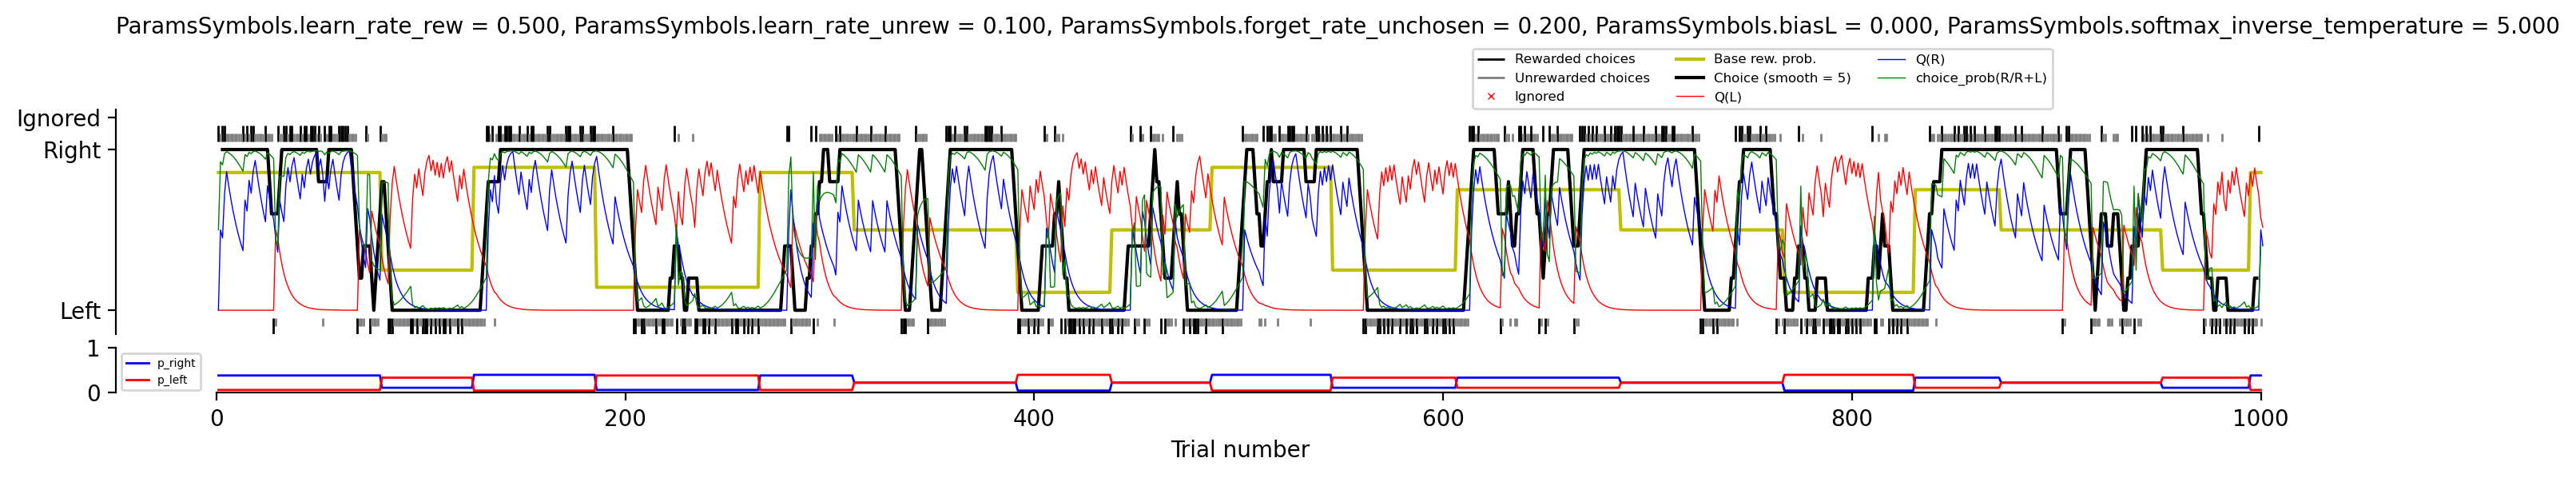

In [7]:
# Run the model
forager.perform(task)

# Get results
ground_truth_params = forager.params.model_dump()
ground_truth_choice_prob = forager.choice_prob
ground_truth_q_value = forager.q_value

# Evaluate the foraging efficiency
foraging_eff, foraging_eff_random_seed = compute_foraging_efficiency(
    baited=task.reward_baiting,
    choice_history=forager.get_choice_history(),
    reward_history=forager.get_reward_history(),
    p_reward=forager.get_p_reward(),
    random_number=task.random_numbers.T,
)

print(f"Foraging efficiency: {foraging_eff:.4f} (random seed: {foraging_eff_random_seed})")

foraging_choice_local, foraging_choice_global = compute_foraging_choice(
    choice_history=forager.get_choice_history(),
    reward_history=forager.get_reward_history(),
    p_reward=forager.get_p_reward(),
    global_calc=None
)

print(f'foraging_choice_local: {foraging_choice_local}, (foraging_choice_global: {foraging_choice_global})')

# Get history
choice_history = forager.get_choice_history()
reward_history = forager.get_reward_history()

# Plot session
fig, axes = forager.plot_session(if_plot_latent=True)

In [8]:
def run_model(n_iterations, task, forager):
    """
    Run model n_iterations and return foraging choice vector 
    """
    local_metrics = []
    global_metrics = []

    foraging_efficiency = []
    foraging_efficiency_random_seed = []

    for _ in range(n_iterations):
        # reset and run model
        forager.reset()
        forager.perform(task)

        # Calculate metrics
        local_metric, global_metric = compute_foraging_choice(
            choice_history=forager.get_choice_history(),
            reward_history=forager.get_reward_history(),
            p_reward=forager.get_p_reward(),
            global_calc=None
        )

        local_metrics.append(local_metric)
        global_metrics.append(global_metric)

        foraging_eff, foraging_eff_random_seed = compute_foraging_efficiency(
            baited=task.reward_baiting,
            choice_history=forager.get_choice_history(),
            reward_history=forager.get_reward_history(),
            p_reward=forager.get_p_reward(),
            random_number=task.random_numbers.T,
        )

        foraging_efficiency.append(foraging_eff)
        foraging_efficiency_random_seed.append(foraging_eff_random_seed)

    return np.array(local_metrics), np.array(global_metrics), np.array(foraging_efficiency), np.array(foraging_efficiency_random_seed)

In [9]:
n_iterations = 1000

local_metrics, global_metrics, foraging_efficiency, foraging_efficiency_random_seed = run_model(n_iterations, task, forager)


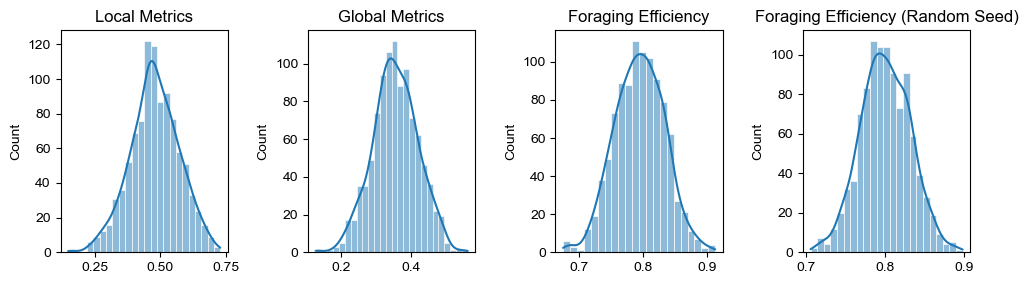

In [10]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 3))
sns.set_theme(style="whitegrid")
sns.histplot(x=local_metrics, kde=True, ax=ax1, label='local_metric')
ax1.set_title('Local Metrics')

sns.histplot(x=global_metrics, kde=True, ax=ax2, label='global_metric')
ax2.set_title('Global Metrics')

sns.histplot(x=foraging_efficiency, kde=True, ax=ax3, label='foraging_efficiency')
ax3.set_title('Foraging Efficiency')

sns.histplot(x=foraging_efficiency_random_seed, kde=True, ax=ax4, label='foraging_efficiency_random_seed')
ax4.set_title('Foraging Efficiency (Random Seed)')

plt.tight_layout()


In [11]:
def param_sweep(tasks, foragers, param_ranges=None, n_repeats=1):
    """
    Sweep over learning rates for metric evaluation

    Params:
    tasks: dict of task environments 
    foragers: dict of forager agents
    param_ranges (dict, optional): dictionary of parameter names and ranges to sweep over, if None use default ranges
    n_repeats (int, optional): number of repeats to run for each parameter combination

    Returns:
    pd.DataFrame: DataFrame containing parameter combinations, task types, agent types, and metrics 
    """
    if param_ranges is None:
        param_ranges = {
            'learn_rate_rew': np.linspace(0.1, 0.9, 5),
            'learn_rate_unrew': np.linspace(0.05, 0.3, 5),
            'forget_rate_unchosen': np.linspace(0.05, 0.3, 5)
        }

    # Convert single instances to dict format
    if not isinstance(tasks, dict):
        tasks = {'default_task': tasks}
    if not isinstance(foragers, dict):
        foragers = {'default_agent': foragers}

    results = []

    # Fixed parameters
    fixed_params = {
        'softmax_inverse_temperature': 5,
        'biasL': 0
    }

    # Calculate total iterations for progress bar
    total_iters = (len(param_ranges['learn_rate_rew']) * 
                  len(param_ranges['learn_rate_unrew']) * 
                  len(param_ranges['forget_rate_unchosen']) * 
                  len(tasks) * len(foragers) * n_repeats)

    # Create progress bar
    pbar = tqdm(total=total_iters)

    # Iterate through parameters 
    for lr_rew in param_ranges['learn_rate_rew']:
        for lr_unrew in param_ranges['learn_rate_unrew']:
            for fr_unchosen in param_ranges['forget_rate_unchosen']:
                # Set parameters
                params = {
                    'learn_rate_rew': lr_rew,
                    'learn_rate_unrew': lr_unrew,
                    'forget_rate_unchosen': fr_unchosen,
                    **fixed_params
                }

                # Iterate through task types
                for task_name, task in tasks.items():
                    # Iterate through forager types
                    for agent_name, forager in foragers.items():
                        # Repeat n times for each parameter combination
                        for repeat in range(n_repeats):
                            forager.reset()
                            forager.params = forager.params.model_copy(update=params)
                            forager.perform(task)

                            # Calculate metrics 
                            local_metric, global_metric = compute_foraging_choice(
                                choice_history=forager.get_choice_history(),
                                reward_history=forager.get_reward_history(),
                                p_reward=forager.get_p_reward(),
                                global_calc=None
                            )

                            foraging_eff, foraging_eff_random_seed = compute_foraging_efficiency(
                                baited=task.reward_baiting,
                                choice_history=forager.get_choice_history(),
                                reward_history=forager.get_reward_history(),
                                p_reward=forager.get_p_reward(),
                                random_number=task.random_numbers.T,
                            )

                            # Store results
                            results.append({
                                'task_type': task_name,
                                'agent_type': agent_name,
                                'repeat': repeat,
                                'learn_rate_rew': lr_rew,
                                'learn_rate_unrew': lr_unrew,
                                'forget_rate_unchosen': fr_unchosen,
                                'local_metric': local_metric,
                                'global_metric': global_metric,
                                'foraging_efficiency': foraging_eff,
                                'foraging_efficiency_random_seed': foraging_eff_random_seed
                            })
                            
                            # Update progress bar
                            pbar.update(1)
                            
    pbar.close()
    return pd.DataFrame(results)


In [12]:
# Set parameter and condition ranges

tasks = {
    'coupled_baited': CoupledBlockTask(reward_baiting=True, num_trials=1000, seed=42),
    'coupled_unbaited': CoupledBlockTask(reward_baiting=False, num_trials=1000, seed=42),
    'uncoupled_baited': UncoupledBlockTask(reward_baiting=True, num_trials=1000, seed=42),
    'uncoupled_unbaited': UncoupledBlockTask(reward_baiting=False, num_trials=1000, seed=42)
}

foragers = {
    'Hattori2019': ForagerCollection().get_preset_forager('Hattori2019', seed=42)
    }

custom_ranges = {
    'learn_rate_rew': np.linspace(0.01, 1, 20),
    'learn_rate_unrew': np.linspace(0.01, 1, 20),
    'forget_rate_unchosen': np.linspace(0.01, 1, 20)
}
# Run the parameter sweep
results_df = param_sweep(tasks, foragers, custom_ranges)

100%|██████████| 32000/32000 [16:00<00:00, 33.30it/s]


In [13]:
results_df

,task_type,agent_type,repeat,learn_rate_rew,learn_rate_unrew,forget_rate_unchosen,local_metric,global_metric,foraging_efficiency,foraging_efficiency_random_seed
0,coupled_baited,Hattori2019,0,0.01,0.01,0.010000,0.016463,0.021459,0.901640,0.906863
1,coupled_unbaited,Hattori2019,0,0.01,0.01,0.010000,-0.032918,0.002214,0.688643,0.673591
2,uncoupled_baited,Hattori2019,0,0.01,0.01,0.010000,0.050630,0.018500,0.780918,0.792929
3,uncoupled_unbaited,Hattori2019,0,0.01,0.01,0.010000,0.135837,0.010500,0.724784,0.736457
4,coupled_baited,Hattori2019,0,0.01,0.01,0.062105,0.080847,0.058694,0.879306,0.872596
...,...,...,...,...,...,...,...,...,...,...
31995,uncoupled_unbaited,Hattori2019,0,1.00,1.00,0.947895,0.455309,0.278500,0.894894,0.884564
31996,coupled_baited,Hattori2019,0,1.00,1.00,1.000000,0.240716,0.185796,0.865394,0.885572
31997,coupled_unbaited,Hattori2019,0,1.00,1.00,1.000000,0.204476,0.157714,0.663327,0.668555
31998,uncoupled_baited,Hattori2019,0,1.00,1.00,1.000000,0.475446,0.264000,0.880580,0.882064


In [14]:
# Find closest values in the actual data

closest_forget = results_df['forget_rate_unchosen'].iloc[(results_df['forget_rate_unchosen'] - 0.2).abs().argsort()[0]]
closest_unrew = results_df['learn_rate_unrew'].iloc[(results_df['learn_rate_unrew'] - 0.1).abs().argsort()[0]]
closest_rew = results_df['learn_rate_rew'].iloc[(results_df['learn_rate_rew'] - 0.5).abs().argsort()[0]]

print(f'Closest forget rate: {closest_forget}, Closest learn rate unrew: {closest_unrew}, Closest learn rate rew: {closest_rew}')

Closest forget rate: 0.21842105263157896, Closest learn rate unrew: 0.11421052631578947, Closest learn rate rew: 0.4789473684210527


In [15]:
# Filter to keep other parameters constant

rew_lr_df = results_df[results_df['forget_rate_unchosen'] == closest_forget]
rew_lr_df = rew_lr_df[rew_lr_df['learn_rate_unrew'] == closest_unrew]

unrew_lr_df = results_df[results_df['learn_rate_rew'] == closest_rew]
unrew_lr_df = unrew_lr_df[unrew_lr_df['forget_rate_unchosen'] == closest_forget]

fr_unchosen_df = results_df[results_df['learn_rate_rew'] == closest_rew]
fr_unchosen_df = fr_unchosen_df[fr_unchosen_df['learn_rate_unrew'] == closest_unrew]


In [16]:
# Create task specific DataFrames

coupled_baiting_df = results_df[results_df['task_type'] == 'coupled_baited']
uncoupled_baiting_df = results_df[results_df['task_type'] == 'uncoupled_baited']
coupled_df = results_df[results_df['task_type'] == 'coupled_unbaited']
uncoupled_df = results_df[results_df['task_type'] == 'uncoupled_unbaited']


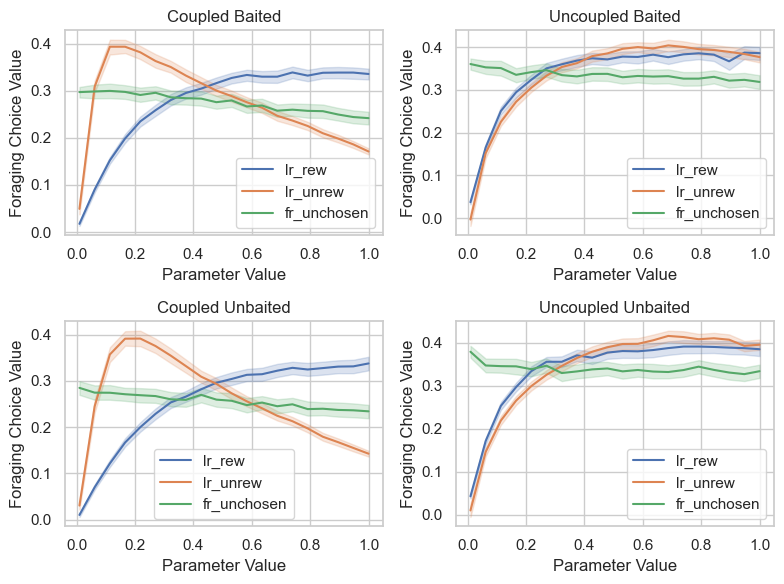

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

task_data = {
    (0,0): (coupled_baiting_df, 'Coupled Baited'),
    (0,1): (uncoupled_baiting_df, 'Uncoupled Baited'),
    (1,0): (coupled_df, 'Coupled Unbaited'),
    (1,1): (uncoupled_df, 'Uncoupled Unbaited')
}

for (i,j), (task_df, title) in task_data.items():
    sns.lineplot(data=task_df, x='learn_rate_rew', y='local_metric', 
                label='lr_rew', ax=axes[i,j])
    sns.lineplot(data=task_df, x='learn_rate_unrew', y='local_metric', 
                label='lr_unrew', ax=axes[i,j])
    sns.lineplot(data=task_df, x='forget_rate_unchosen', y='local_metric', 
                label='fr_unchosen', ax=axes[i,j])

    axes[i,j].set_title(title)
    axes[i,j].set_xlabel('Parameter Value')
    axes[i,j].set_ylabel('Foraging Choice Value')
    axes[i,j].legend()

plt.tight_layout()
plt.show()

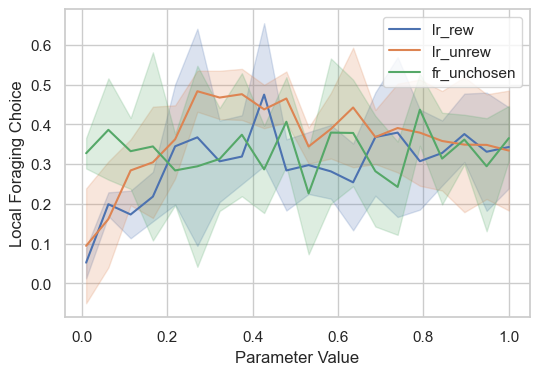

In [18]:
plt.figure(figsize=(6, 4))
sns.lineplot(rew_lr_df, x='learn_rate_rew', y='local_metric', label='lr_rew')
sns.lineplot(unrew_lr_df, x='learn_rate_unrew', y='local_metric', label='lr_unrew')
sns.lineplot(fr_unchosen_df, x='forget_rate_unchosen', y='local_metric', label='fr_unchosen')
plt.xlabel('Parameter Value')
plt.ylabel('Local Foraging Choice')
plt.legend()
plt.show()

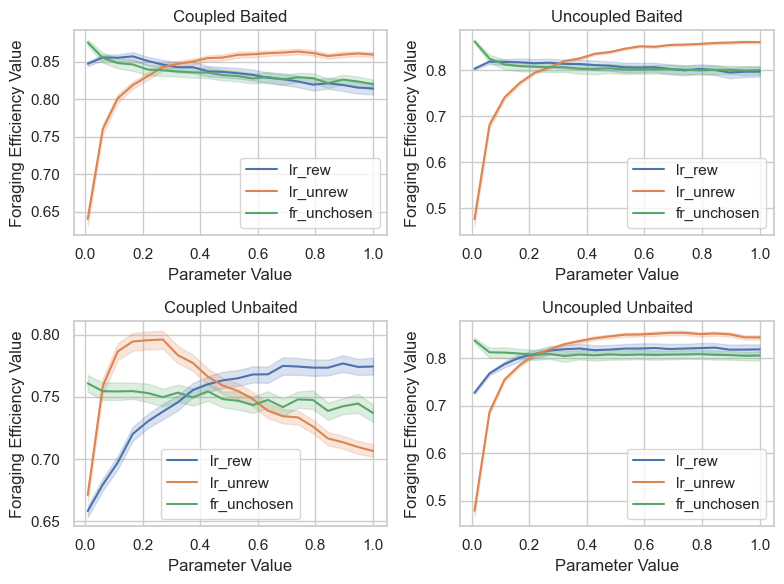

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

for (i,j), (task_df, title) in task_data.items():
    sns.lineplot(data=task_df, x='learn_rate_rew', y='foraging_efficiency', 
                label='lr_rew', ax=axes[i,j])
    sns.lineplot(data=task_df, x='learn_rate_unrew', y='foraging_efficiency', 
                label='lr_unrew', ax=axes[i,j])
    sns.lineplot(data=task_df, x='forget_rate_unchosen', y='foraging_efficiency', 
                label='fr_unchosen', ax=axes[i,j])
    
    axes[i,j].set_title(title)
    axes[i,j].set_xlabel('Parameter Value')
    axes[i,j].set_ylabel('Foraging Efficiency Value')
    axes[i,j].legend()

plt.tight_layout()
plt.show()

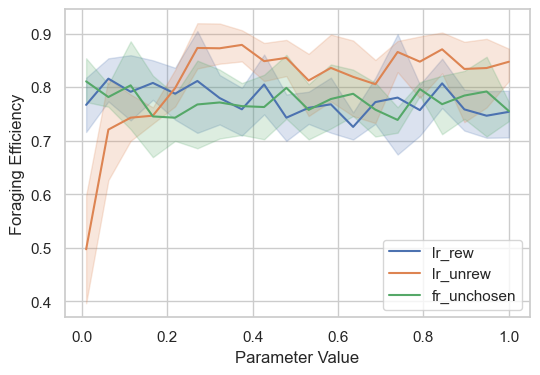

In [20]:
plt.figure(figsize=(6, 4))
sns.lineplot(rew_lr_df, x='learn_rate_rew', y='foraging_efficiency', label='lr_rew')
sns.lineplot(unrew_lr_df, x='learn_rate_unrew', y='foraging_efficiency', label='lr_unrew')
sns.lineplot(fr_unchosen_df, x='forget_rate_unchosen', y='foraging_efficiency', label='fr_unchosen')
plt.xlabel('Parameter Value')
plt.ylabel('Foraging Efficiency')
plt.legend()
plt.show()


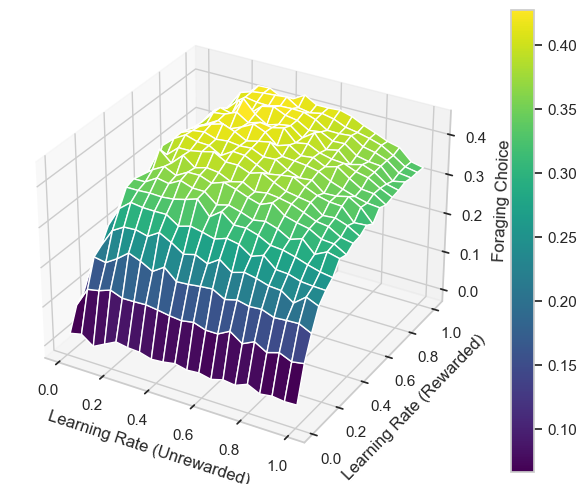

In [21]:
# Additional plots (mean FC / lr_rew, lr_unrew)

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')

pivot = results_df.pivot_table(
    values='local_metric',
    index='learn_rate_rew', 
    columns='learn_rate_unrew',
    aggfunc='mean'
)
X, Y = np.meshgrid(pivot.columns, pivot.index)

surf = ax.plot_surface(X, Y, pivot.values, cmap='viridis')
ax.set_xlabel('Learning Rate (Unrewarded)')
ax.set_ylabel('Learning Rate (Rewarded)') 
ax.set_zlabel('Foraging Choice')
plt.colorbar(surf)
plt.show()

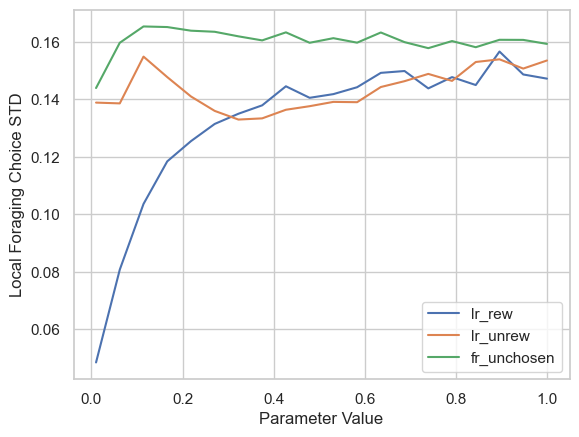

In [22]:
# Parameter sensitivity 
sensitivity_fc = pd.DataFrame({
    'learn_rate_rew': results_df.groupby('learn_rate_rew')['local_metric'].std(),
    'learn_rate_unrew': results_df.groupby('learn_rate_unrew')['local_metric'].std(),
    'forget_rate': results_df.groupby('forget_rate_unchosen')['local_metric'].std()
})

sns.lineplot(sensitivity_fc, x=sensitivity_fc.index, y='learn_rate_rew', label='lr_rew')
sns.lineplot(sensitivity_fc, x=sensitivity_fc.index, y='learn_rate_unrew', label='lr_unrew')
sns.lineplot(sensitivity_fc, x=sensitivity_fc.index, y='forget_rate', label='fr_unchosen')
plt.xlabel('Parameter Value')
plt.ylabel('Local Foraging Choice STD')
plt.legend()
plt.show()


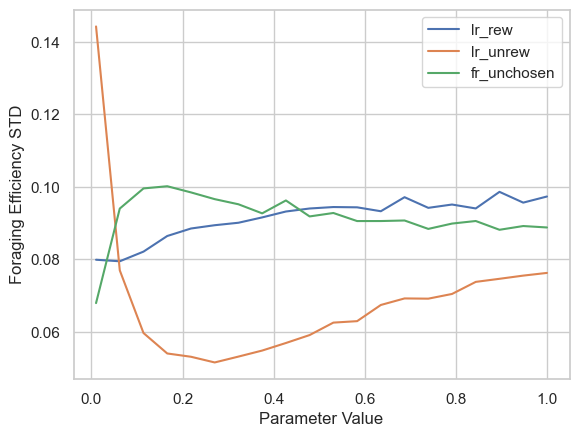

In [23]:
# Parameter sensitivity 
sensitivity_fe = pd.DataFrame({
    'learn_rate_rew': results_df.groupby('learn_rate_rew')['foraging_efficiency'].std(),
    'learn_rate_unrew': results_df.groupby('learn_rate_unrew')['foraging_efficiency'].std(),
    'forget_rate': results_df.groupby('forget_rate_unchosen')['foraging_efficiency'].std()
})

sns.lineplot(sensitivity_fe, x=sensitivity_fe.index, y='learn_rate_rew', label='lr_rew')
sns.lineplot(sensitivity_fe, x=sensitivity_fe.index, y='learn_rate_unrew', label='lr_unrew')
sns.lineplot(sensitivity_fe, x=sensitivity_fe.index, y='forget_rate', label='fr_unchosen')
plt.xlabel('Parameter Value')
plt.ylabel('Foraging Efficiency STD')
plt.legend()
plt.show()


In [24]:
# Parameter recovery 

# Fit model to recover parameters

forager.fit(
    choice_history,
    reward_history,
    fit_bounds_override = {'softmax_inverse_temperature': [0, 100]},
    clamp_params = {'biasL': 0},
    DE_kwargs = dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation = None,
)

fitting_results = forager.fitting_result

2024-12-20 08:18:21,070 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 289.0829807952948
differential_evolution step 2: f(x)= 278.66081064312925
differential_evolution step 3: f(x)= 271.07233761947083
differential_evolution step 4: f(x)= 271.07233761947083
differential_evolution step 5: f(x)= 271.07233761947083
differential_evolution step 6: f(x)= 267.7258166159626
differential_evolution step 7: f(x)= 267.7258166159626
differential_evolution step 8: f(x)= 267.7258166159626
differential_evolution step 9: f(x)= 261.55107374493673
differential_evolution step 10: f(x)= 261.1578133089714
differential_evolution step 11: f(x)= 261.1578133089714
differential_evolution step 12: f(x)= 259.92281388759886
differential_evolution step 13: f(x)= 258.0116776498438
differential_evolution step 14: f(x)= 258.0116776498438
differential_evolution step 15: f(x)= 258.0116776498438
differential_evolution step 16: f(x)= 258.0116776498438
differential_evolution step 17: f(x)= 258.0116776498438
differential_evolution step 18: f(x)= 258.011677649

In [25]:
# Check fitted parameters 
fit_names = fitting_results.fit_settings['fit_names']
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f'Num of trials: {len(choice_history)}')
print(f'Fitted parameters: {fit_names}')
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_results.x]}')
print(f"Likelihood-Per-Trial: {fitting_results.LPT}")
print(f"Prediction accuracy full dataset: {fitting_results.prediction_accuracy}\n")

Num of trials: 1000
Fitted parameters: ['learn_rate_rew', 'learn_rate_unrew', 'forget_rate_unchosen', 'softmax_inverse_temperature']
Ground truth: ['0.5000', '0.1000', '0.2000', '5.0000']
Fitted:       ['0.6011', '0.1087', '0.1544', '4.8908']
Likelihood-Per-Trial: 0.7732456884626638
Prediction accuracy full dataset: 0.902



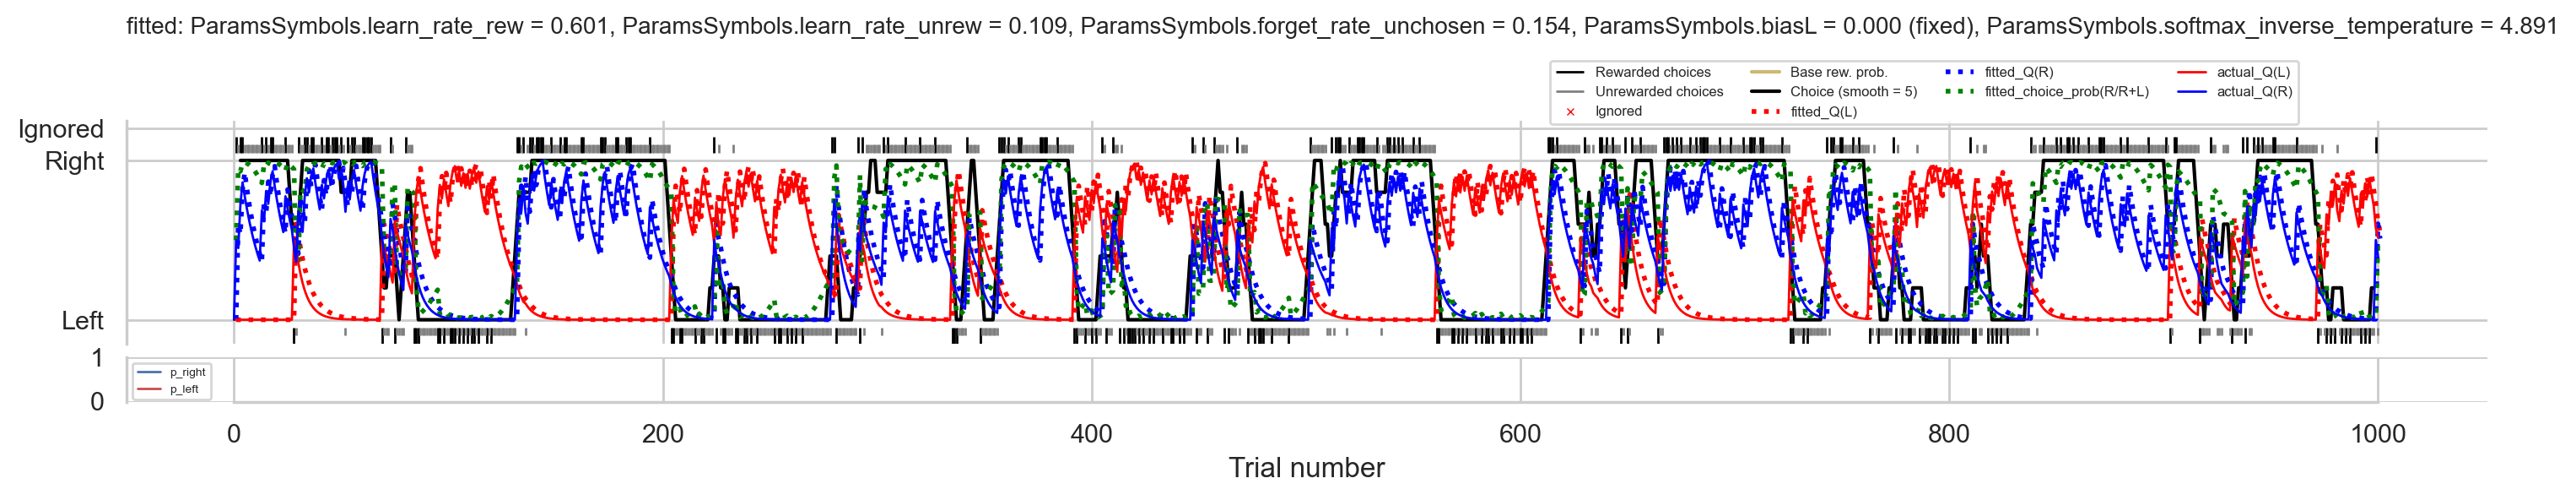

In [26]:
# Plot fitted session results

fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

# Overlay ground truth Q values
axes[0].plot(ground_truth_q_value[0], lw=1, color="red", ls="-", label="actual_Q(L)")
axes[0].plot(ground_truth_q_value[1], lw=1, color="blue", ls="-", label="actual_Q(R)")
axes[0].legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.6, 1.3), ncol=4)

##### Test Noisy data in FC environment #####

In [4]:
# Load in preprocessed data
foraging_filepath = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/foraging_trials_bonsai.csv'

foraging_df = pd.read_csv(foraging_filepath)

# Drop extraneous subject
foraging_df = foraging_df[foraging_df['subject_id'] != 111111]

foraging_df.sort_values(['subject_id', 'session_date', 'trial'], inplace=True)

# Single DataFrame for testing **

subject = 769887
date = '2024-11-04'
subject_df = foraging_df[foraging_df['subject_id'] == subject]
subject_df = subject_df[subject_df['session_date'] == date]

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_96419/89732766.py:4: DtypeWarning: Columns (31,38,40,42,52) have mixed types. Specify dtype option on import or set low_memory=False.
  foraging_df = pd.read_csv(foraging_filepath)


In [5]:
testing_df = subject_df.loc[:, ['animal_response', 'rewarded_historyL', 'rewarded_historyR', 'reward_probabilityL', 'reward_probabilityR', 'auto_waterL', 'auto_waterR']]

for col in testing_df.columns:
    print(f"\n{col}:")
    print("Data type:", testing_df[col].dtype)
    print("Number of unique values:", testing_df[col].nunique())
    print("Missing values:", testing_df[col].isnull().sum())
    if testing_df[col].dtype in ['int64', 'float64']:
        if col in ['auto_waterL', 'auto_waterR']:
            print("Value counts:")
            print("1:", (testing_df[col] == 1).sum())
            print("0:", (testing_df[col] == 0).sum())
        else:
            print("Mean:", testing_df[col].mean())
            print("Std:", testing_df[col].std())
            print("Min:", testing_df[col].min())
            print("Max:", testing_df[col].max())
    if testing_df[col].dtype == 'bool':
        print("Value counts:")
        print("1 (True):", (testing_df[col] == 1).sum())
        print("0 (False):", (testing_df[col] == 0).sum())
    print("-----------------------")

print("\nFirst few rows of the dataframe:")
print("\nShape of dataframe:", testing_df.shape)
print("\nLength of each column:")
for col in testing_df.columns:
    print(f"{col}: {len(testing_df[col])}")


animal_response:
Data type: float64
Number of unique values: 3
Missing values: 0
Mean: 1.0875420875420876
Std: 0.8686480467287573
Min: 0.0
Max: 2.0
-----------------------

rewarded_historyL:
Data type: bool
Number of unique values: 2
Missing values: 0
Value counts:
1 (True): 30
0 (False): 564
-----------------------

rewarded_historyR:
Data type: bool
Number of unique values: 2
Missing values: 0
Value counts:
1 (True): 29
0 (False): 565
-----------------------

reward_probabilityL:
Data type: float64
Number of unique values: 3
Missing values: 0
Mean: 0.2956228956228957
Std: 0.3976503916051249
Min: 0.0
Max: 1.0
-----------------------

reward_probabilityR:
Data type: float64
Number of unique values: 3
Missing values: 0
Mean: 0.5215488215488214
Std: 0.39230407529669264
Min: 0.0
Max: 1.0
-----------------------

auto_waterL:
Data type: int64
Number of unique values: 2
Missing values: 0
Value counts:
1: 72
0: 522
-----------------------

auto_waterR:
Data type: int64
Number of unique val

In [6]:
# Use FC metric with old DataFrame input

def add_block_transitions_and_stats_filt(df):
    """
    Identifies block transitions and calculates block statistics for a foraging dataframe.
    """
    # Identify block transitions based on probability changes
    block_transitions = ((df['reward_probabilityL'].shift() != df['reward_probabilityL']) | 
                        (df['reward_probabilityR'].shift() != df['reward_probabilityR'])).astype(int)
    
    # First trial is always a block transition (matching numpy version)
    block_transitions.iloc[0] = 1
    
    # Create unique block numbers within each session
    df['block'] = block_transitions.groupby([df['subject_id'], 
                                           df['session_date']]).cumsum() - 1  # Subtract 1 to start at 0
    
    # Calculate block statistics
    block_lengths = df.groupby(['subject_id', 'session_date', 'block']).size()
    block_stats = block_lengths.groupby(['subject_id', 'session_date']).agg(['max', 'median'])
    
    # Add block statistics back to original dataframe
    df['max_block_length'] = df.set_index(['subject_id', 'session_date']).index.map(block_stats['max'])
    df['median_block_length'] = df.set_index(['subject_id', 'session_date']).index.map(block_stats['median'])
    
    return df

In [7]:
foraging_df_filt = add_block_transitions_and_stats_filt(foraging_df)
foraging_df_filt.head()

,trial,animal_response,rewarded_historyL,rewarded_historyR,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,...,choice_time_in_trial,earned_reward,extra_reward,subject_id,session_date,reward_delay,minimum_opto_interval,block,max_block_length,median_block_length
1447552,0,2.0,False,False,False,False,0.80,0.088889,0.711111,0.909618,...,NaN,False,False,567890,2024-11-01,0.0,0.0,0,2,2.0
1447553,1,2.0,False,False,False,True,0.80,0.088889,0.711111,0.807069,...,NaN,False,False,567890,2024-11-01,0.0,0.0,0,2,2.0
868421,0,2.0,False,False,True,False,0.80,0.711111,0.088889,0.426309,...,NaN,False,False,641733,2024-01-24,0.0,0.0,0,2,2.0
868422,1,2.0,False,False,True,False,0.80,0.711111,0.088889,0.554599,...,NaN,False,False,641733,2024-01-24,0.0,0.0,0,2,2.0
142214,0,1.0,False,False,False,False,0.45,0.400000,0.050000,0.925068,...,0.43744,False,False,684039,2023-10-25,NaN,NaN,0,57,40.0


In [8]:
# Define chosen metric difference function

def chosen_metric_difference(df, global_calc=True):
    """
    Current difference calculation method
    """
    grouped = df.groupby(['subject_id', 'session_date'])
    results = []
    
    for (subject, date), session_df in grouped:
        session_df['probability_chosen'] = np.where(
            session_df['animal_response'] == 0,
            session_df['reward_probabilityL'],
            session_df['reward_probabilityR']
        )
        session_df['probability_not_chosen'] = np.where(
            session_df['animal_response'] == 0,
            session_df['reward_probabilityR'],
            session_df['reward_probabilityL']
        )
        
        if global_calc:
            difference = session_df['probability_chosen'] - session_df['probability_not_chosen']
            
            p_larger_global = max(session_df['probability_chosen'].max(), 
                                session_df['probability_not_chosen'].max())
            p_smaller_global = min(session_df['probability_chosen'].min(), 
                                 session_df['probability_not_chosen'].min())
            
            if p_larger_global == p_smaller_global:
                continue
                
            final_metric = difference.mean() / (p_larger_global - p_smaller_global)
            
            results.append({
                'subject_id': subject,
                'session_date': date,
                'chosen_metric': final_metric,
            })
            
        else:
            block_metrics = []
            
            for block_num, block_df in session_df.groupby('block'):
                difference = block_df['probability_chosen'] - block_df['probability_not_chosen']
                
                p_larger_block = max(block_df['probability_chosen'].max(),
                                   block_df['probability_not_chosen'].max())
                p_smaller_block = min(block_df['probability_chosen'].min(),
                                    block_df['probability_not_chosen'].min())
                
                if p_larger_block == p_smaller_block:
                    continue
                    
                block_metric = difference.mean() / (p_larger_block - p_smaller_block)
                block_metrics.append(block_metric)
            
            if block_metrics:
                results.append({
                    'subject_id': subject,
                    'session_date': date,
                    'chosen_metric': np.mean(block_metrics),
                })
    
    return pd.DataFrame(results)

In [9]:
diff_local_filt = chosen_metric_difference(foraging_df_filt, global_calc=False)
diff_global_filt = chosen_metric_difference(foraging_df_filt, global_calc=True)

# Compare results
diff_all = pd.concat([
    diff_global_filt.assign(method='diff_global'),
    diff_local_filt.assign(method='diff_local'),
])

print(f'local_metric: {diff_local_filt["chosen_metric"]}')
print(f'global_metric: {diff_global_filt["chosen_metric"]}')

local_metric: 0       1.000000
1      -1.000000
2       0.326422
3       0.352656
4       0.219818
          ...   
5258   -0.020706
5259    0.755944
5260    0.205583
5261    0.258780
5262    0.323770
Name: chosen_metric, Length: 5263, dtype: float64
global_metric: 0       1.000000
1      -1.000000
2       0.437186
3       0.405660
4       0.086022
          ...   
5258   -0.021834
5259    0.192099
5260    0.131367
5261    0.014286
5262    0.196262
Name: chosen_metric, Length: 5263, dtype: float64


In [10]:
subject = 769887
date = '2024-12-09'

diff_local_filt['session_date'] = diff_local_filt['session_date'].astype('datetime64[ns]')
diff_local_filt['subject_id'] = diff_local_filt['subject_id'].astype('int64')

individual_local = diff_local_filt[diff_local_filt['subject_id'] == subject]

individual_local

,subject_id,session_date,chosen_metric
5257,769887,2024-11-04,0.722261
5258,769887,2024-11-06,-0.020706


In [11]:
# Load in session level metrics 

session_metrics = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv')
session_metrics['session_date'] = session_metrics['session_date'].astype('datetime64[ns]')

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_96419/1577903200.py:3: DtypeWarning: Columns (6,7,8,11,26,27,28,29,30,133,134,149,150,151,152,153,154,155,156,157,158,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  session_metrics = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv')


In [12]:
session_metrics.sort_values(['subject_id', 'session_date'], inplace=True)
session_metrics.head()

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,subject_genotype,fiber_probes,injections,task_type,virus,NM_recorded,results,results_location,session_time,docDB_status
8915,447921,2019-09-11,135646,1.0,Training-Tower-3_bpod,Nai-Wen Tien,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
8906,447921,2019-09-12,212547,2.0,Training-Tower-3_bpod,Nai-Wen Tien,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
8905,447921,2019-09-13,155249,3.0,Training-Tower-3_bpod,Nai-Wen Tien,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
8898,447921,2019-09-14,153203,4.0,Training-Tower-3_bpod,Nai-Wen Tien,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
8897,447921,2019-09-15,122712,5.0,Training-Tower-3_bpod,Nai-Wen Tien,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded


In [13]:
# Preprocessing

# Merge calculated metrics with session metrics 

diff_all['session_date'] = diff_all['session_date'].astype('datetime64[ns]')
diff_global_filt['session_date'] = diff_global_filt['session_date'].astype('datetime64[ns]')
diff_local_filt['session_date'] = diff_local_filt['session_date'].astype('datetime64[ns]')

diff_all_merged = bu.merge_dataframes_subject_id(diff_all, session_metrics)
diff_global_merged = bu.merge_dataframes_subject_id(diff_global_filt, session_metrics)
diff_local_merged = bu.merge_dataframes_subject_id(diff_local_filt, session_metrics)

pd.set_option('future.no_silent_downcasting', True)

# Remove extraneous columns

extraneous_columns = [ 'nwb_suffix',
 'rig',
 'user_name',
 'notes',
 'experiment_description',
 'session_start_time',
 'session_end_time',
 'session_run_time_in_min',
 'base_weight',
 'target_weight',
 'target_weight_ratio',
 'weight_after',
 'laser_1_calibration_power',
 'laser_2_calibration_power',
 'laser_1_target_areas',
 'laser_2_target_areas',
 'commit_ID',
 'repo_url',
 'current_branch',
 'lickspout_movement_range_x',
 'lickspout_movement_range_y',
 'lickspout_movement_range_z',
 'lickspout_initial_pos_x',
 'lickspout_initial_pos_y',
 'lickspout_initial_pos_z',
 'lickspout_median_pos_x',
 'lickspout_median_pos_y',
 'lickspout_median_pos_z',
 'has_video',
 'has_ephys',
 'old_bpod_session',
 'h2o',
 'institute',
 'rig_type',
 'room',
 'hardware',
 'data_source',
'location',
 'session_name',
 'creation_time',
 'co_data_asset_ID',
 'subject_genotype',
 'fiber_probes',
 'injections',
 'task_type',
 'virus',
 'NM_recorded',
 'results',
 'results_location',
 'session_time',
 'docDB_status'
 ]

diff_all_merged = bu.remove_columns(diff_all_merged, extraneous_columns)
diff_global_merged = bu.remove_columns(diff_global_merged, extraneous_columns)
diff_local_merged = bu.remove_columns(diff_local_merged, extraneous_columns)
# Clean DataFrames

diff_all_merged = bu.clean_dataframe(diff_all_merged, threshold=0.1)
diff_global_merged = bu.clean_dataframe(diff_global_merged, threshold=0.1)
diff_local_merged = bu.clean_dataframe(diff_local_merged, threshold=0.1)
# Add session column 'new_sesssion

diff_all_comp= bu.add_session_column(diff_all_merged)
diff_global_comp = bu.add_session_column(diff_global_merged)
diff_local_comp = bu.add_session_column(diff_local_merged)


Original DataFrame shape: (8996, 114)
Cleaned DataFrame shape: (8838, 114)

Original DataFrame shape: (4498, 113)
Cleaned DataFrame shape: (4419, 113)

Original DataFrame shape: (4498, 113)
Cleaned DataFrame shape: (4419, 113)


In [14]:
# Normalize by block length (testing)

# Not working

def normalize_by_block_length(df, median=False, max=False):
    """
    Normalize metrics by block length by dividing chosen_metric by either the median or max block length.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing metrics to normalize
        median (bool): If True, normalize by effective_block_length_median
        max (bool): If True, normalize by effective_block_length_max
        
    Returns:
        pd.DataFrame: DataFrame with normalized chosen_metric and first 5 sessions removed
    """
    # Remove first 5 sessions
    df = df[df['new_session'] > 5].copy()
    
    if median:
        df['chosen_metric'] = (df['chosen_metric'] / df['effective_block_length_median']) * 1000
    elif max:
        df['chosen_metric'] = (df['chosen_metric'] / df['effective_block_length_max']) * 1000
    return df

In [15]:
norm_local_median = normalize_by_block_length(diff_local_comp, median=True)
norm_local_max = normalize_by_block_length(diff_local_comp, max=True)

norm_global_median = normalize_by_block_length(diff_global_comp, median=True)
norm_global_max = normalize_by_block_length(diff_global_comp, max=True)

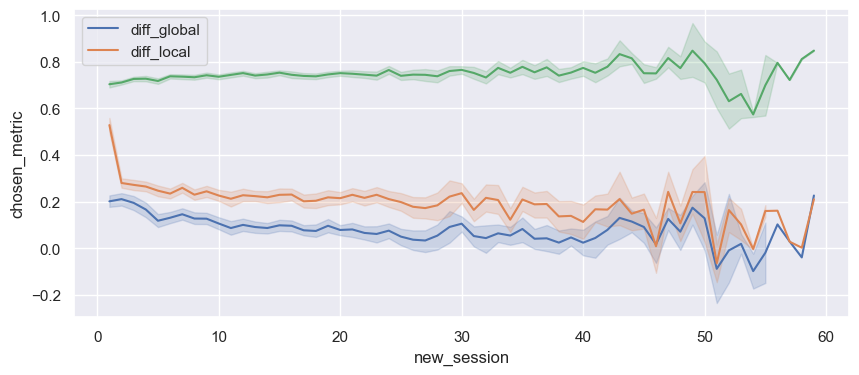

In [16]:
plt.figure(figsize=(10, 4))
sns.lineplot(diff_all_comp, x='new_session', y='chosen_metric', hue='method')
sns.lineplot(diff_all_comp, x='new_session', y='foraging_eff_random_seed')
plt.legend()

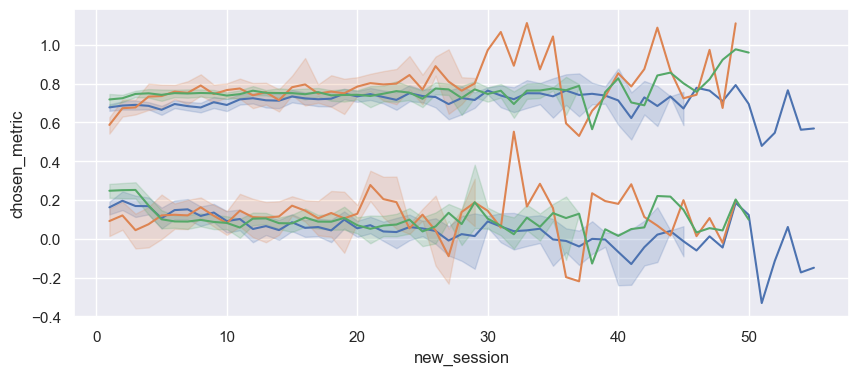

In [17]:
plt.figure(figsize=(10, 4))
sns.lineplot(diff_global_comp, x='new_session', y='chosen_metric', hue='curriculum_name')
sns.lineplot(diff_global_comp, x='new_session', y='foraging_eff_random_seed', hue='curriculum_name')
plt.legend().remove()

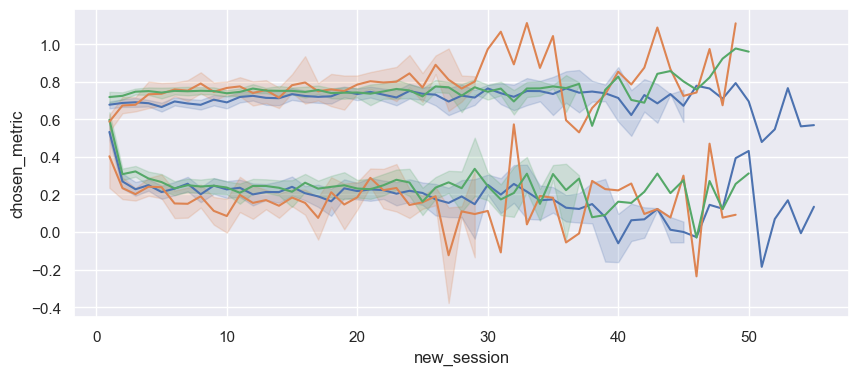

In [18]:
plt.figure(figsize=(10, 4))
sns.lineplot(diff_local_comp, x='new_session', y='chosen_metric', hue='curriculum_name')
sns.lineplot(diff_local_comp, x='new_session', y='foraging_eff_random_seed', hue='curriculum_name')
plt.legend().remove()

In [19]:
# Explore version history

version_dict = bu.analyze_column_distribution(diff_all_comp, 'curriculum_version')
version_dict


{'value_counts': curriculum_version
 2.3                 2074
 2.2                  790
 1.0                  742
 2.3.1rwdDelay159     712
 2.2.1rwdDelay159     634
 2.0                  306
 2.1rwdDelay159       266
 2.2rwdDelay159       170
 2.1                  146
 2.3rwdDelay159       104
 0.1                   56
 0.1                    2
 Name: count, dtype: int64,
 'percentages': curriculum_version
 2.3                 34.555148
 2.2                 13.162279
 1.0                 12.362546
 2.3.1rwdDelay159    11.862712
 2.2.1rwdDelay159    10.563146
 2.0                  5.098301
 2.1rwdDelay159       4.431856
 2.2rwdDelay159       2.832389
 2.1                  2.432522
 2.3rwdDelay159       1.732756
 0.1                  0.933022
 0.1                  0.033322
 Name: proportion, dtype: float64,
 'total_count': 8838,
 'unique_values': 12,
 'most_common': ('2.3', 2074),
 'least_common': ('0.1', 2)}

In [22]:
# Filter by curriculum version
filtered_local = bu.filter_by_column(diff_local_comp, 'curriculum_version', '2.3')
filtered_global = bu.filter_by_column(diff_global_comp, 'curriculum_version', '2.3')
filtered_all = bu.filter_by_column(diff_all_comp, 'curriculum_version', '2.3')

# Filter by stage
filtered_local = bu.filter_by_column(filtered_local, 'current_stage_actual', 'STAGE_FINAL')
filtered_global = bu.filter_by_column(filtered_global, 'current_stage_actual', 'STAGE_FINAL')
filtered_all = bu.filter_by_column(filtered_all, 'current_stage_actual', 'STAGE_FINAL')

# Filter by task
filtered_local = bu.filter_by_column(filtered_local, 'task', 'Uncoupled Baiting', reset_sessions=True)
filtered_global = bu.filter_by_column(filtered_global, 'task', 'Uncoupled Baiting', reset_sessions=True)
filtered_all = bu.filter_by_column(filtered_all, 'task', 'Uncoupled Baiting', reset_sessions=True)

filtered_all['task'].unique()

array(['Uncoupled Baiting'], dtype=object)

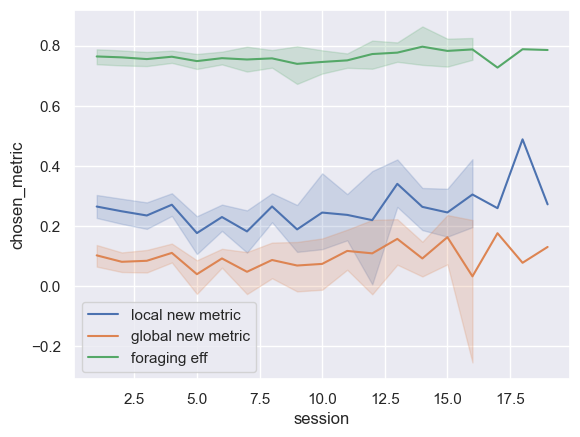

In [23]:
sns.lineplot(filtered_local, x='session', y='chosen_metric', label='local new metric')
sns.lineplot(filtered_global, x='session', y='chosen_metric', label='global new metric')
sns.lineplot(filtered_local, x='session', y='foraging_eff_random_seed', label='foraging eff')

plt.legend()